In [26]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
# read all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [28]:
len(words)

32033

In [29]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [30]:
# build the dataset
block_size = 3 # context length : how many characters do we take to pedioct the next one

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [66]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of nuerons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
w1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
w2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# Initially the logits should be low and not very high numbers because that means
# the model is confident or biased for some of the output which it has no reasons 
# to be, hence the scaling down of w2 and b2

# while using batch normalisation we don't want the actiations to always be normally 
# distributed so we add aditional weights and bias after normalisation so that once 
# the activation is normalised they are allowed to shift there mean and deviations too.
# the weights set to 1 and bias to zero makes sure initial the normal distribution is same 
# but the parameters can be leraned.

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, w1, b1, w2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [67]:
# We fixed the softmax confidently wrong issue by scaling down the weights and bias initialization 
# of the last layer since having a large actiavtion at the very first iteration will result into 
# large loss in the very first iterations of the training. Also having large weights and bias in the 
# hidden layers may result into the activation functions to fall into the flat regions of the activation 
# functions which may result in the gradients to either be zero or just passing through the neuron.

In [68]:
# same optimization as last time
max_step = 200000
batch_size = 32
lossi = []

for i in range(max_step):
    # mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # embed the character into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    bnmeani = hpreact.mean((0, keepdim=True))
    bnstdi = hpreact.std((0, keepdim=True))
    hpreact = embcat @ w1 + b1 # hidden layer pre activation
    # batch normalisation
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = bnmean_running * 0.999 + bnmeani * 0.001
        bnstd_running = bnstd_running * 0.999 + bnstdi * 0.001
    
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
#     print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_step:7d} : {loss.item():.4f}")
    lossi.append(loss.log10().item())
#     break
    
print(loss.item())

      0/ 200000 : 3.3147
  10000/ 200000 : 2.1341
  20000/ 200000 : 2.3173
  30000/ 200000 : 2.4115
  40000/ 200000 : 2.0124
  50000/ 200000 : 2.3003
  60000/ 200000 : 2.4708
  70000/ 200000 : 2.1208
  80000/ 200000 : 2.3562
  90000/ 200000 : 2.1095
 100000/ 200000 : 1.9329
 110000/ 200000 : 2.3919
 120000/ 200000 : 1.9795
 130000/ 200000 : 2.4764
 140000/ 200000 : 2.3703
 150000/ 200000 : 2.3098
 160000/ 200000 : 2.0003
 170000/ 200000 : 1.8345
 180000/ 200000 : 2.0355
 190000/ 200000 : 1.8853
2.369077205657959


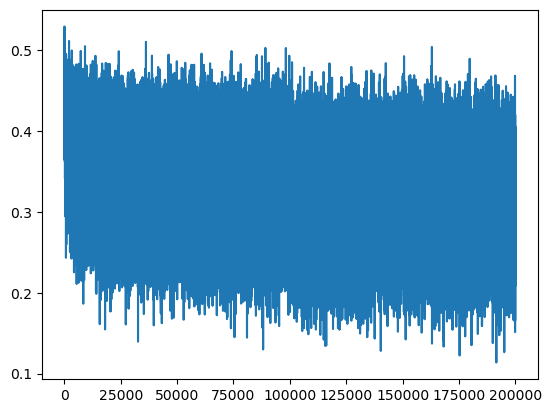

In [69]:
plt.plot(lossi)

In [ ]:
# caliberate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ w1 + b1
    # measure the mean/std over the entire training set 
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [70]:
@torch.no_grad() # this decorator disables the gradient tracking

def split_loss(split):
    x, y = {
        'train' : (Xtr, Ytr),
        'val' : (Xdev, Ydev), 
        'test' : (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size, n_embd)
    hpreact = embcat @ w1 + b1
#     hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)) + bnbias
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ w2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0620570182800293
val 2.1022262573242188


In [71]:
# sample from the model 
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
            
    print(''.join(itos[i] for i in out))

bria.
bmyah.
shermadhvyah.
bethruthjdrvez.
sherpdrt.
bissapprpnleighsvanshantellysshmpra.
brshdrvrsshignnsthn.
jestlynextth.
bruububrcdyshym.
samels.
bab.
qusflyasshan.
sadylysuntzallyssupmiy.
brukslevokten.
zdid.
quinsobhghptix.
sumgeyna.
hurabluislaislegr.
brwally.
brthbrizthreghikassaitgf.
